In [44]:
# Imports
import numpy as np
import pandas as pd
import itertools
import os
import matplotlib.pyplot as plt

In [50]:
class GaezData:
    """ Load data from GAEZv3 website. Adapted from Daniel Kondor."""
    # initialize class variables
    _ncols = 0
    _nrows = 0
    _xll, _yll = 0, 0 # reference point (southwest) for lat / long coordinates
    _csize = 0 # size of cell
    _no_data_val = 0 # value that denotes invalid data
    _values = np.array([]) # holds crop yields
    _r_km = 6371 # mean earth radius

    def _key_validate(self, k, v):
        """
        Validate one line of metadata read from the input file
        """
        if k == "ncols":
            self._ncols = int(v)
        elif k == "nrows":
            self._nrows = int(v)
        elif k == "xllcorner":
            self._xll = float(v)
        elif k == "yllcorner":
            self._yll = float(v)
        elif k == "cellsize":
            self._csize = float(v)
        elif k == "NODATA_value":
            self._no_data_val = int(v)
        else:
            raise Exception("GaezData._key_validate(): invalid metadata key!\n")

    def load(self, fn, dtype=np.int32):
        """
        Load data in a grid from the given file. Assumes .asc file format for now.
        The parameter dtype can specify the type of data in the file; it will be used to create the data matrices.
        """
        with open(fn) as f1:
            i = 0
            # first six lines are metadata # TODO: Check for future data sets
            while i < 6:
                l1 = f1.readline()
                l2 = l1.split()
                if len(l2) == 0:
                    continue
                if len(l2) != 2: # valid metadata contains two tab-separated words
                    raise Exception("GaezData.load(): invalid metadata!\n")
                self._key_validate(*l2)
                i += 1

            # check if metadata is valid
            if self._ncols <= 0 or self._nrows <= 0 or self._csize <= 0:
                raise Exception("GaezData.load(): invalid metadata!\n")

            self._values = np.zeros([self._nrows, self._ncols], dtype=dtype)
            # note: data is referenced to lower left (southwest) corner. array has origin at upper left corner.
            # note: invert row order
            for i in range(self._nrows):
                l1 = f1.readline()
                self._values[self._nrows - i - 1, :] = [dtype(y) for y in l1.split()]

    def get_value_xy(self, x, y):
        # TODO: Array support
        if x >= self._ncols or y >= self._nrows or x < 0 or y < 0:
            raise Exception("gaezdata.get_value_xy(): position out of range!\n")
        return self._values[y, x]

    def lonlat_to_xy(self, lon, lat):
        """
        note: xll gives longitude (east / west) and yll latitude (north / south) of reference point
        example: lat (0, 0) = lat (reference point) = lat (xll, yll) -> (x=0, y=0)
        """
        x = int(round((lon - self._xll) / self._csize))
        y = int(round((lat - self._yll) / self._csize))
        return x, y

    def xy_to_lonlat(self, x, y):
        lon = self._xll + x * self._csize
        lat = self._yll + y * self._csize
        return lon, lat

    def get_value_lonlat(self, lon, lat):
        """
        goal: retrieve yield at given lat / lon coordinates.
        needed: convert lat / long to index (i.e. x, y) - > retrieve element at index
        """
        x, y = self.lonlat_to_xy(lon, lat)
        return self.get_value_xy(x, y)

    def get_values_in_study_area(self, xsize, ysize, off_x, off_y):
        """ Denote study area by x / y offset (convert from lat / long) and slices along x and y."""
        # create a matrix of yield values only in the study area
        slice_1d = self._values[off_y:(off_y + ysize), off_x:(off_x + xsize)]
        return slice_1d.reshape([ysize, xsize])

    def get_arc_distance(self, lat1, lat2, del_lon):
        """Get distance between the two points specified by two latitude coordinates and a relative longitude
        coordinate according to the Haversine formula."""
        # Convert to radians
        lat1 *= np.pi / 180
        lat2 *= np.pi / 180
        del_lon *= np.pi / 180

        # Apply haversine
        a = np.sin((lat1 - lat2) / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(del_lon / 2) ** 2
        c = 2 * np.atan2(np.sqrt(a), np.sqrt(1 - a))
        distance = self._r_km * c
        return distance

    def get_distance_matrix(self, x1, x2, y1, y2):
        """ Get a (_nrows, _ncols) matrix where each entry denotes the Euclidean distance between two cells
         with (\Delta x, \Delta y)."""

        # Get lon / lat grid
        lon_diff_values = np.linspace(0, self._ncols, self._csize) # start from zero to max. distance
        lat_diff_values = np.linspace(0, self._nrows, self._csize)

        # Convert to radians
        lon_diff_values *= np.pi / 180
        lat_diff_values += np.pi / 180

        # Get meshgrid
        lon_grid, lat_grid = np.meshgrid(lon_diff_values, lat_diff_values, indexing="ij") # keep longitude as row column

        # Apply haversine formula
        # But haversine formula ALSO depends on the specific lat1 and lat2 values, and not just on the difference. F.
        a = np.sin(lat_grid / 2) ** 2 + np.cos(lat_grid + self._yll) * np.cos(lat2_rad) * np.sin(lon_grid / 2) ** 2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))
        distance = self._r_km * c





In [51]:
# 1. Load the potential yield datasets
base_dir = r"C:\Users\leoko\Documents\Vienna_CSH"
data_base_dir = os.path.join(base_dir, "winter_wheat_data")
file_name = os.path.join(data_base_dir, "data.asc")

# create instance and load
crop_data = GaezData()
crop_data.load(file_name, dtype=float)

# re-define offset for EU
eu_lon = -12 # lower left corner for EU
eu_lat = 36.5
eu_x, eu_y = crop_data.lonlat_to_xy(eu_lon, eu_lat)

x_size = 732 # size of the grid used in the current study - i.e. slices along row / column
y_size = 258

# matrix of yield values in study area
crop_data_eu = crop_data.get_values_in_study_area(x_size, y_size, eu_x, eu_y)

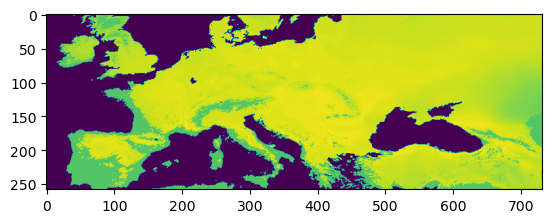

In [54]:
plt.imshow(np.flip(crop_data_eu, axis=0))

In [ ]:
crop_data_combined_df = pd.DataFrame([
    {'x' : x, 'y' : y, 'v' : crop_data_eu[x, y]} for (x, y) in
    itertools.product(range(x_size), range(y_size)) if crop_data_combined[x, y] > 0
    ])
# 130745 valid rows

# add IDs to the grid cells that are used
crop_data_combined_df['id'] = crop_data_combined_df.y * xsize + crop_data_combined_df.x

# add coordinates -- note that these are the centers of the cells
crop_data_combined_df['lon'] = eu_x + (crop_data_combined_df.x + 0.5) / 12.0
crop_data_combined_df['lat'] = eu_y + (crop_data_combined_df.y + 0.5) / 12.0

# same in a CSV format that is easy to use later
crop_data_combined_df.to_csv('{}/eu_combined_estimate.csv'.format(data_base_dir), index=False)

In [23]:
with open(os.path.join(data_base_dir, "data.asc"), mode="r") as f:
    count = 0
    for line in f:
        if count < 6:
            print(line)
        count += 1

    print(count)


ncols        4319

nrows        2084

xllcorner    -180.000000000000

yllcorner    -89.916666666667

cellsize     0.083333333333

NODATA_value     -9

2090
